In [34]:
#Importing necessary python libraries
import sqlite3
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model  import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [35]:
#Read in the cleaned Coronary Artery Disease (CAD) dataset.
file_path = '../Data/Cleaned Data/complete_cleaned_cad.csv'
cad_df = pd.read_csv(file_path)
cad_df.head()

,Age,Gender,BMI,Race,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,Smoker,Non_HDL,DM,MI,CAD
0,69,1,26.7,4,86.0,0,554.0,113.0,74.0,0,600.0,0,102.0,2,0,0
1,54,1,28.6,3,74.0,0,219.0,157.0,61.0,0,540.0,1,120.0,2,0,0
2,72,1,28.9,3,68.0,0,183.0,142.0,82.0,1,300.0,0,66.0,2,0,0
3,73,0,19.7,3,92.0,0,104.0,137.0,87.0,1,480.0,0,116.0,0,0,0
4,56,1,41.7,1,60.0,0,104.0,157.0,82.0,0,360.0,0,188.0,0,1,1


In [36]:
#Drop MI (Miocardial Infarction (Heart Attack)) Column
cad_df.drop(columns=['MI'], inplace=True)
cad_df.head()

,Age,Gender,BMI,Race,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,Smoker,Non_HDL,DM,CAD
0,69,1,26.7,4,86.0,0,554.0,113.0,74.0,0,600.0,0,102.0,2,0
1,54,1,28.6,3,74.0,0,219.0,157.0,61.0,0,540.0,1,120.0,2,0
2,72,1,28.9,3,68.0,0,183.0,142.0,82.0,1,300.0,0,66.0,2,0
3,73,0,19.7,3,92.0,0,104.0,137.0,87.0,1,480.0,0,116.0,0,0
4,56,1,41.7,1,60.0,0,104.0,157.0,82.0,0,360.0,0,188.0,0,1


In [37]:
#Encoding race categories to binary categories
cad_df = pd.get_dummies(cad_df, columns=(['Race', 'DM']))
cad_df.head()

,Age,Gender,BMI,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,...,CAD,Race_1,Race_2,Race_3,Race_4,Race_5,Race_6,DM_0,DM_1,DM_2
0,69,1,26.7,86.0,0,554.0,113.0,74.0,0,600.0,...,0,0,0,0,1,0,0,0,0,1
1,54,1,28.6,74.0,0,219.0,157.0,61.0,0,540.0,...,0,0,0,1,0,0,0,0,0,1
2,72,1,28.9,68.0,0,183.0,142.0,82.0,1,300.0,...,0,0,0,1,0,0,0,0,0,1
3,73,0,19.7,92.0,0,104.0,137.0,87.0,1,480.0,...,0,0,0,1,0,0,0,1,0,0
4,56,1,41.7,60.0,0,104.0,157.0,82.0,0,360.0,...,1,1,0,0,0,0,0,1,0,0


In [38]:
# Define Target Variable
y = cad_df.CAD

# Drop Target Variable From Data
X = cad_df.drop(columns=('CAD'))
X.head()

,Age,Gender,BMI,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,...,Non_HDL,Race_1,Race_2,Race_3,Race_4,Race_5,Race_6,DM_0,DM_1,DM_2
0,69,1,26.7,86.0,0,554.0,113.0,74.0,0,600.0,...,102.0,0,0,0,1,0,0,0,0,1
1,54,1,28.6,74.0,0,219.0,157.0,61.0,0,540.0,...,120.0,0,0,1,0,0,0,0,0,1
2,72,1,28.9,68.0,0,183.0,142.0,82.0,1,300.0,...,66.0,0,0,1,0,0,0,0,0,1
3,73,0,19.7,92.0,0,104.0,137.0,87.0,1,480.0,...,116.0,0,0,1,0,0,0,1,0,0
4,56,1,41.7,60.0,0,104.0,157.0,82.0,0,360.0,...,188.0,1,0,0,0,0,0,1,0,0


In [39]:
smote = SMOTE()
X, y = smote.fit_resample(X, y)
y.value_counts()

1    5113
0    5113
Name: CAD, dtype: int64

In [40]:
#Split Data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# smote = SMOTE()
# X_train_smote, y_train_smote,  = smote.fit_resample(X_train, y_train)

# print(f'Minority Class before smote: {y_train.value_counts().iloc[1]}')
# print(f'Majority Class before smote: {y_train.value_counts().iloc[0]}')
# print(f'Minority Class after smote: {y_train_smote.value_counts().iloc[1]}')
# print(f'Majority Class after smote: {y_train.value_counts().iloc[0]}')

In [59]:
# dt_clf = DecisionTreeClassifier() 
# dt_clf.fit(X_train_smote, y_train_smote)
# y_test_pred = dt_clf.predict(X_test)
# y_train_pred = dt_clf.predict(X_train_smote)
# train_score = accuracy_score(y_train_smote, y_train_pred)
# test_score = accuracy_score(y_test, y_test_pred)

In [41]:
def clf(classifier):
    model = classifier
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    train_score = accuracy_score(y_train, y_train_pred)
    test_score = accuracy_score(y_test, y_test_pred)
    cm = confusion_matrix(y_test, y_test_pred)
    print(f'''Training Data Prediction Accuracy: {round(train_score, 2)}
Testing Data Prediction Accuracy: {round(test_score, 2)}
                                 ''')
    print(f'''True Negatives: {cm[0][0]}
False Negatives: {cm[1][0]}
False Positives: {cm[0][1]}
True Positives: {cm[1][1]}''')
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_disp.plot()
    plt.title(f'Confusion Matrix')
    plt.show()

Decision Tree Classifier

Training Data Prediction Accuracy: 1.0
Testing Data Prediction Accuracy: 0.93
                                 
True Negatives: 1194
False Negatives: 49
False Positives: 124
True Positives: 1190


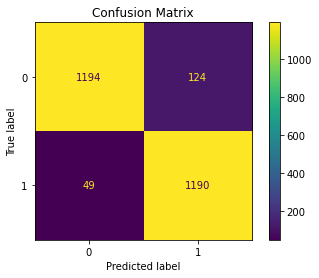

Random Forest Classifier

Training Data Prediction Accuracy: 1.0
Testing Data Prediction Accuracy: 0.97
                                 
True Negatives: 1280
False Negatives: 28
False Positives: 38
True Positives: 1211


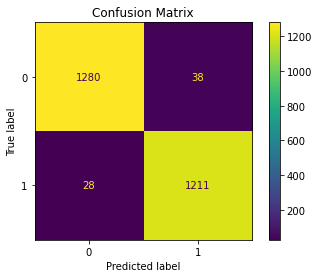

XGBoost Classifier

Training Data Prediction Accuracy: 0.99
Testing Data Prediction Accuracy: 0.98
                                 
True Negatives: 1280
False Negatives: 25
False Positives: 38
True Positives: 1214


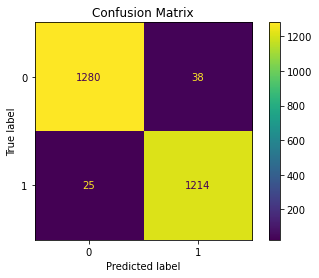

In [86]:
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
xgb_clf = XGBClassifier(max_depth=4)
classifiers = {'Decision Tree Classifier': dt_clf, 'Random Forest Classifier': rf_clf, 'XGBoost Classifier': xgb_clf}
for i in range(3):
    print(list(classifiers.keys())[i])
    print('')
    clf(list(classifiers.values())[i])

In [62]:
classifiers = {'Decision Tree Classifier': dt_clf, 'Random Forest Classifier': rf_clf, 'XGBoost Classifier': xgb_clf}
classifiers.keys()

dict_keys(['Decision Tree Classifier', 'Random Forest Classifier', 'XGBoost Classifier'])